In [1]:
from datavyz.main import graph_env # my custom dataviz environment
ge = graph_env('screen') # initialize a visualization env optimize for notebook display
import numpy as np

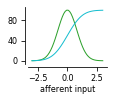

In [2]:
from analyz.signal_library.classical_functions import gaussian, gaussian_cumproba
x = np.linspace(-3,3)
fig, ax = ge.figure(with_legend_space=True)
ge.plot(x, 100.*gaussian(x, std=0.8)/np.max(gaussian(x, std=0.8)), ax=ax, no_set=True, color=ge.g)
ge.plot(x, 100.*gaussian_cumproba(x), ax=ax, no_set=True, color=ge.cyan)
ge.set_plot(ax, xlabel='afferent input', ylabel='')

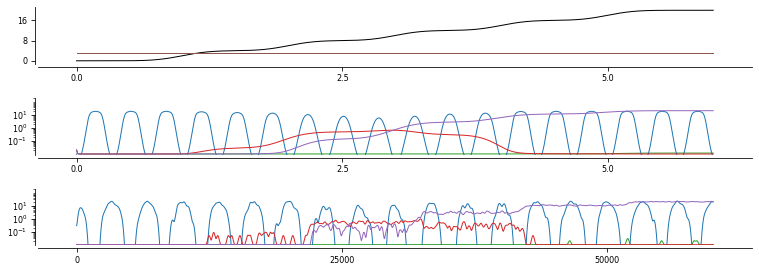

In [3]:
# c
import numpy as np

import neural_network_dynamics.main as ntwk

from analyz.processing.signanalysis import gaussian_smoothing as smooth
from datavyz.main import graph_env

from model import Model, REC_POPS, AFF_POPS

data = ntwk.load_dict_from_hdf5('draft_data.h5')

tstop, dt = 1e-3*data['tstop'], 1e-2
t = np.arange(int(tstop/dt))*dt

DYN_SYSTEM, INPUTS = {}, {}
for rec in REC_POPS:
    Model['COEFFS_%s' % rec] = np.load('data/COEFFS_pyrExc.npy')
    DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-2}
    INPUTS['AffExc_%s' % rec] = smooth(np.array([4.*int(tt) for tt in t]), int(.2/dt))
    INPUTS['NoiseExc_%s' % rec] = 3+0*t

CURRENT_INPUTS = {'oscillExc':Model['oscillExc_Ioscill_amp']*(1-np.cos(Model['oscillExc_Ioscill_freq']*2*np.pi*t))/2.}

X = ntwk.mean_field.solve_mean_field_first_order(Model,
                                                 DYN_SYSTEM,
                                                 INPUTS=INPUTS,
                                                 CURRENT_INPUTS=CURRENT_INPUTS,
                                                 dt=dt, tstop=tstop)

ge = graph_env()
fig, [ax0,ax1,ax2] = ge.figure(axes=(3,1), figsize=(3.,1.))

ge.plot(t, Y=[INPUTS['AffExc_pyrExc'], INPUTS['NoiseExc_pyrExc']], COLORS=['k', ge.brown], ax=ax0)
ge.plot(t, Y=[X['pyrExc']+1e-2, X['oscillExc'], X['recInh']+1e-2, X['dsInh']+1e-2],
        COLORS=[ge.g, ge.b, ge.r, ge.purple], ax=ax1, axes_args=dict(yticks=[0.1,1.,10], ylim=[.9e-2, 200], yscale='log'))
ge.plot(Y=[smooth(x, 100) for x in [data['POP_ACT_pyrExc']+1e-2, data['POP_ACT_oscillExc'], data['POP_ACT_recInh']+1e-2, data['POP_ACT_dsInh']+1e-2]], 
        COLORS=[ge.g, ge.b, ge.r, ge.purple], ax=ax2, axes_args=dict(yticks=[0.1,1.,10], ylim=[.9e-2, 200], yscale='log'))    
Fmf = X

In [72]:

from neural_network_dynamics import main as ntwk
from model import *

# generate the function
data = np.load('data/tf_data.npy', allow_pickle=True).item()
data['Model']['COEFFS'] = np.load('data/COEFFS_pyrExc.npy')

nrn_params = ntwk.built_up_neuron_params(data['Model'], 'pyrExc')
syn_input = ntwk.build_up_afferent_synaptic_input(data['Model'],
                                                  ['pyrExc', 'recInh'], 'pyrExc')


N = 40
Ioscill = np.linspace(-1, 20*10, N-1)
Freq_Exc = np.logspace(np.log10(10), np.log10(10000), N+1)
Freq_Inh = np.logspace(np.log10(10), np.log10(10000), N)


import itertools

points, output_freq = [], []
output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))
for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)), range(len(Ioscill))):
    points.append([Freq_Exc[i], Freq_Inh[j], Ioscill[k]])
    output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                                    {'F_pyrExc':Freq_Exc[i], 'F_recInh':Freq_Inh[j]},
                                                    data['Model']['COEFFS'],
                                                    current_input=Ioscill[k])
points = np.array(points)

firing_lower_threshold = 1e-2

output_freq = np.array(output_freq)
output_freq[output_freq<firing_lower_threshold] = firing_lower_threshold

In [5]:
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator([Freq_Exc, Freq_Inh, Ioscill],
                               output_freq,
                               method='linear',
                               fill_value=None, bounds_error=False)

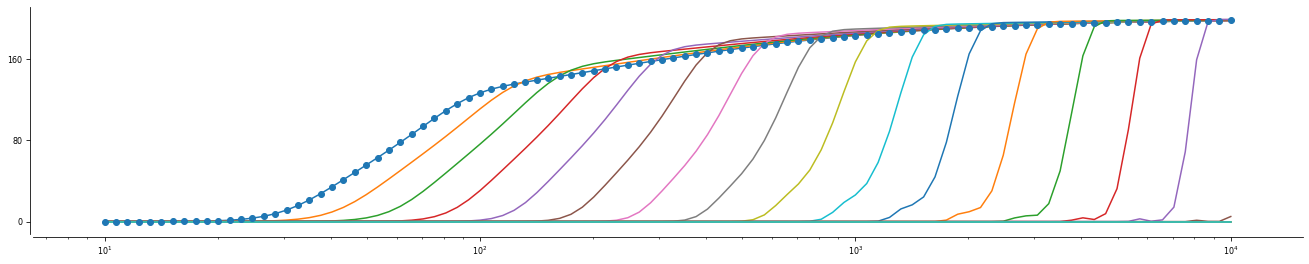

In [6]:
fig, ax = ge.figure(figsize=(4,4))
freq = np.logspace(np.log10(10.), np.log10(10000), 100)
for i, fi in enumerate(np.logspace(np.log10(10), np.log10(10000), 20)):
    ax.plot(freq, func([[f, fi, 0] for f in freq]))


ax.plot(Freq_Exc, output_freq[:,0,0], 'o')
#ge.set_plot(ax, xscale='log', yscale='log')
ge.set_plot(ax, xscale='log')

In [7]:
%time x=[func([i, 200, 0.1]) for i in range(200)]        

CPU times: user 69.7 ms, sys: 8.62 ms, total: 78.3 ms
Wall time: 62.2 ms


In [34]:
# designing the 

#tstop, dt = 1e-3*data['tstop'], 1e-2
#t = np.arange(int(tstop/dt))*dt

Connectivity_Matrix = None

# F array in to order of REC_POPS
F = np.ones(len(REC_POPS))
A = np.ones(len(AFF_POPS))

# Connectivity matrix of size (a+f, f)
C = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))

# connectivity matrix of excitatory interactions
Cexc = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))

# connectivity matrix of excitatory interactions
Cinh = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))

# building the connectivities for the ODE solver
for i, ii in enumerate(REC_POPS+AFF_POPS):
    for j, jj in enumerate(REC_POPS):
        if Connectivity_Matrix is None:
            C[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]
        else:
            C[i,j] = Connectivity_Matrix[i,j]
        if len(ii.split('Exc'))>1:
            Cexc[i,j] = C[i,j]
        elif len(ii.split('Inh'))>1:
            Cinh[i,j] = C[i,j]
        else:
            print('/!\ %s is not classified as Exc or Inh' % ii+jj)

# building the input arrays
def func_Fafferent(tt):
    if tt>1:
        return np.array([1.,
                         1.])
    else:
        return np.array([1.,
                         1.])

# building the non-synaptic currents
def func_Iintrinsic(tt):
    if tt>40e-3:
        return np.array([0,
                         200,
                         0,
                         0])
    else:
        return np.zeros(4)

from scipy.integrate import odeint

def growth_factor(X, t):
    
    Fexc_over_pops = np.dot(np.concatenate([X, func_Fafferent(t)]),
                            Cexc)
    Finh_over_pops = np.dot(np.concatenate([X,func_Fafferent(t)]),
                            Cinh)

    return np.array([func([Fexc_over_pops[i],
                           Finh_over_pops[i],
                           func_Iintrinsic(t)[i]])[0] for i in range(len(REC_POPS))])
    
def dX_dt(X, t, tau=5e-3):
    
    return (growth_factor(X,t)-X)/tau
    
dt, tstop = 1e-4, 0.1
t = np.arange(int(tstop/dt))*dt
X0 = np.ones(len(REC_POPS))*1
X = odeint(dX_dt, X0, t)#, args=(func_Iintrinsic, func_Fafferent))

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7efc646bff90>)

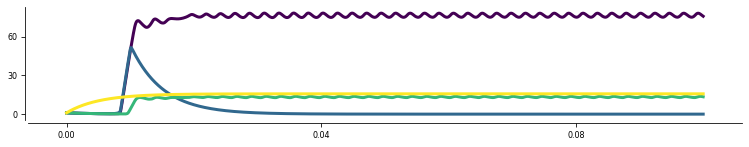

In [35]:
fig, ax=ge.figure(figsize=(3,2))
#ge.plot(t, Y=[Fmf['pyrExc']+1e-2, Fmf['oscillExc']+1e-2], ax=ax, COLORS=['k', ge.brown])
ge.plot(t, Y=X.T, ax=ax, lw=3)

[ 7927.55438942  8218.15566795 15921.10877883    72.        ]


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7efc54e3da90>)

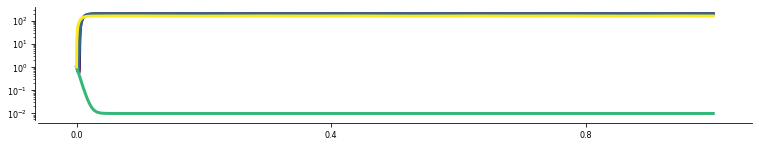

In [69]:
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt
Y = np.ones((len(t),len(REC_POPS)))*1

def Fexc_over_pops(X, t):
    return np.dot(np.concatenate([X, [3.,3.]]), Cexc)

def Finh_over_pops(X, t):
    return np.dot(np.concatenate([X, [3.,3.]]), Cinh)

def growth_factor(X, t):
    
    #Fexc_over_pops = np.dot(np.concatenate([X, func_Fafferent(t)]), Cexc)
    #Finh_over_pops = np.dot(np.concatenate([X,func_Fafferent(t)]), Cinh)
    
    return np.array([func([Fexc_over_pops(X,t)[i],
                           Finh_over_pops(X,t)[i],
                           100*(1-np.cos(2*np.pi*3*t))])[0] for i in range(len(REC_POPS))])


tau=5e-3
for it, tt in enumerate(t[1:]):
    Y[it+1,:] = Y[it,:]+dt*(growth_factor(Y[it,:],tt)-Y[it,:])/tau
    
print(Fexc_over_pops(Y[-1], t[-1]))
fig, ax=ge.figure(figsize=(3,2))
ge.plot(t, Y=Y.T+1e-2, ax=ax, lw=3, axes_args=dict(yscale='log'))

In [70]:
Cexc

array([[40., 40., 80.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 5.,  0., 20., 20.],
       [ 4., 40., 20.,  4.]])

[ 28.2 132.  126.   73.2] [0. 0. 0. 0.]


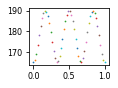

In [542]:
X = [0, 0, 0, 0]
t=.3
Fexc_over_pops = np.dot(Cexc.T,
                            np.concatenate([X, func_Fafferent(t)]))
Finh_over_pops = np.dot(Cinh.T,
                            np.concatenate([X,func_Fafferent(t)]))

i=1
print(Fexc_over_pops, Finh_over_pops)
fig, ax = ge.figure()
for t in np.linspace(0,1):
    #ax.scatter([t], [func([Fexc_over_pops[i], Finh_over_pops[i], func_Iintrinsic(t)[i]])], s=0.5)
    ax.scatter([t], [func([160, 0, func_Iintrinsic(t)[i]])], s=0.5)


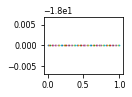

In [527]:
X = np.ones(4)*1e-1
i=1
fig, ax = ge.figure()
for t in np.linspace(0,1):
    ax.scatter([t], [dX_dt(X,t)[i]], s=0.5)

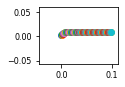

In [528]:
X = np.ones(4)*0

dt = 1e-3

fig, ax= ge.figure()
for it in range(100):
    X = X + dX_dt(X,it*dt)*dt
    ax.scatter([it*dt], [X[1]])
    #ax.scatter([it*dt], [dX_dt(X,float(it*dt))[1]])
                

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7febdad6eb90>)

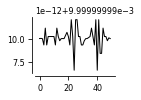

In [430]:
ge.plot([func([40, 0, func_Iintrinsic(tt)[1]]) for tt in np.linspace(0,1)])

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7febdd9fc8d0>)

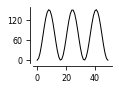

In [239]:
ge.plot([func_Iintrinsic(tt)[1] for tt in np.linspace(0,1)])

In [410]:
np.dot(np.concatenate([F,A]), Cexc)

array([ 49.,  81., 120.,  24.])

In [131]:
REC_POPS

['pyrExc', 'oscillExc', 'recInh', 'dsInh']

In [43]:
Cexc

array([[0.01, 0.01, 0.02, 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.2 , 0.2 ],
       [0.02, 0.2 , 0.1 , 0.02]])

In [44]:
Cinh

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.1 , 0.05, 0.  ],
       [0.  , 0.  , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])

In [75]:
Fexc_over_pops = np.dot(Cexc.T, np.concatenate([F,A]))
Finh_over_pops = np.dot(Cinh.T, np.concatenate([F,A]))
I=0
(func([[fe, fi, I] for fe, fi in zip(Fexc_over_pops, Finh_over_pops)])-F)    

array([-0.99, -0.99, -0.99, -0.99])

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7febd9ef4490>)

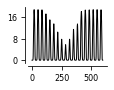

In [573]:
ge.plot(Fmf['oscillExc'])

In [ ]:
from model import *


data['Model']['N_AffExc'] = 1
data['Model']['p_AffExc_pyrExc'] = 1.
data['Model']['N_NoiseExc'] = 1
data['Model']['p_Noise_pyrExc'] = 1.
data['Model']['N_recInh'] = 1
data['Model']['p_recInh_pyrExc'] = 1.
data['Model']['N_pyrExc'] = 1
data['Model']['p_pyrExc_pyrExc'] = 1
